/tmp/ipykernel_3799859/1281442291.py:84: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_win, y_win, 1)
/tmp/ipykernel_3799859/1281442291.py:84: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_win, y_win, 1)
/tmp/ipykernel_3799859/1281442291.py:84: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_win, y_win, 1)


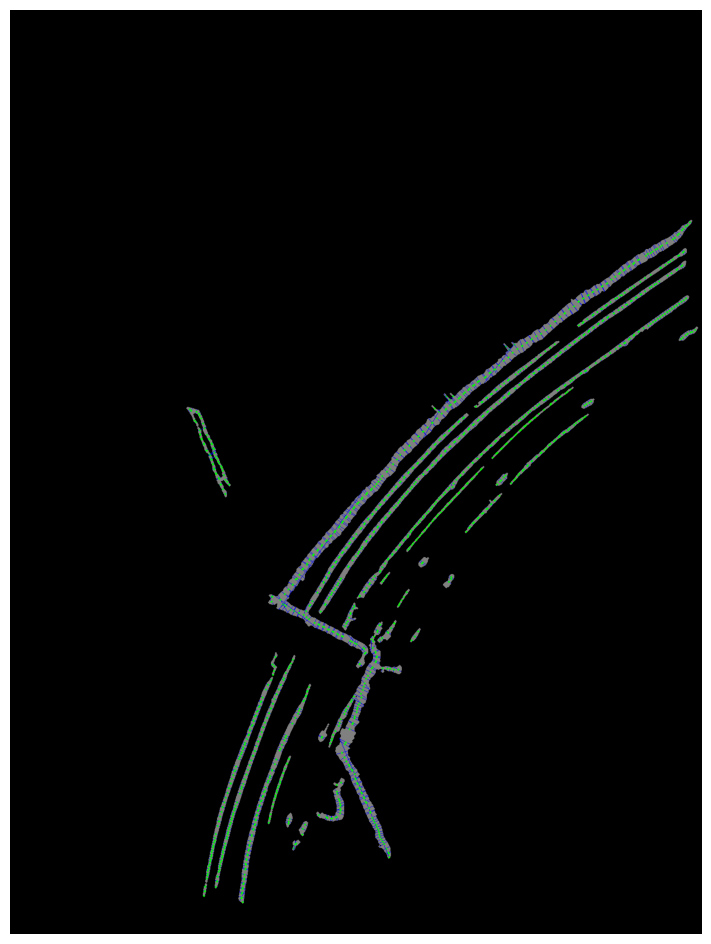

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

def fast_thinning(img):
    skel = np.zeros(img.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    while True:
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        temp = img - open
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return skel

def find_distance(x0, y0, direction, binary_img):
    step_size = 8
    current_dist = 0
    dir_x, dir_y = direction
    while step_size >= 1:
        new_x = int(x0 + dir_x * (current_dist + step_size))
        new_y = int(y0 + dir_y * (current_dist + step_size))
        if (0 <= new_x < binary_img.shape[1] and 
            0 <= new_y < binary_img.shape[0] and 
            binary_img[new_y, new_x]):
            current_dist += step_size
        else:
            step_size //= 2
    return current_dist

# Cargar imagen y preprocesar
img_pretil = cv2.imread('testing/inference_dem_3/pretil_epoch_96.exr', cv2.IMREAD_UNCHANGED)
img = cv2.imread('testing/inference_dem_3/class_epoch_96.png', cv2.IMREAD_COLOR)

img_green = img[:, :, 1]
img_red = img[:, :, 2]
img_blue = img[:, :, 0]

green_mask = (img_green > img_red) & (img_green > img_blue)
binary_img = np.uint8(green_mask) * 255

# Mejorar máscara
binary_img = cv2.medianBlur(binary_img, 3)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=1)

# Conectividad
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, 8)
valid_components = [i for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] > 150]

binary_mask = binary_img.astype(bool)
visualization_img = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype=np.uint8)
results = []

for component in valid_components:
    mask = (labels == component).astype(np.uint8)
    skeleton = fast_thinning(mask)
    
    # Obtener puntos ordenados del esqueleto
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    visualization_img[mask.astype(bool)] = [128, 128, 128]
    
    for contour in contours:
        contour = contour.reshape(-1, 2)
        num_points = contour.shape[0]
        if num_points < 10:
            continue
        
        # Procesar ventanas de 10 puntos
        for i in range(0, num_points - 9, 10):
            window = contour[i:i+10]
            x_win = window[:, 0]
            y_win = window[:, 1]
            
            # Regresión lineal
            try:
                coeffs = np.polyfit(x_win, y_win, 1)
                m = coeffs[0]
                dx, dy = 1, m
                length = np.hypot(dx, dy)
                dir_x, dir_y = dx/length, dy/length
            except:
                # Fallback a puntos extremos
                dx = x_win[-1] - x_win[0]
                dy = y_win[-1] - y_win[0]
                length = np.hypot(dx, dy)
                if length == 0:
                    continue
                dir_x, dir_y = dx/length, dy/length
            
            # Direcciones perpendiculares
            perp_up = (-dir_y, dir_x)
            perp_down = (dir_y, -dir_x)
            
            # Punto medio de la ventana
            mid_idx = i + 5
            x0, y0 = contour[mid_idx]
            
            # Calcular distancias
            d_up = find_distance(x0, y0, perp_up, binary_mask)
            d_down = find_distance(x0, y0, perp_down, binary_mask)
            width = (d_up + d_down) * 0.25

            start_x = int(x0 - perp_up[0] * d_down)
            start_y = int(y0 - perp_up[1] * d_down)
            end_x = int(x0 + perp_up[0] * d_up)
            end_y = int(y0 + perp_up[1] * d_up)
            
            cv2.line(visualization_img, (start_x, start_y), (end_x, end_y), (0,0,255), 1)
            cv2.circle(visualization_img, (x0, y0), 2, (0,255,0), -1)
            
            height = img_pretil[y0, x0]
            results.append((x0, y0,component,width,height)) 

plt.figure(figsize=(12,12))
plt.imshow(visualization_img)
plt.axis('off')
plt.show()

In [2]:
import pyproj
from preprocessing import subsample_point_cloud, create_digital_elevation_model

path = '../data/reduced_Inspecciones_Aéreas_Cámara_L2_Lidar_1.las'
las = subsample_point_cloud(path, factor=100)
mean_x, mean_y = np.mean(las.x), np.mean(las.y) 

dem_info = create_digital_elevation_model(las.x, las.y, las.z)


In [18]:
def get_grid_values(dem_info, w, h):

    grid_x, grid_y = dem_info.get('grid_x'), dem_info.get('grid_y')

    if not (0 <= w < grid_x.shape[1] and 0 <= h < grid_x.shape[0]):
        raise IndexError("Las coordenadas (w, h) están fuera de los límites de las matrices.")

    # Recuperar los valores de grid_x y grid_y en la posición (w, h)
    value_x = grid_x[h, w]
    value_y = grid_y[h, w]

    return value_x, value_y

def transform_19s_wgs84(coord_e, coord_n):
    source_crs = f"EPSG:32719"  # 19s   
    target_crs = "EPSG:4326"    # WGS84 for Google Maps

    transformer = pyproj.Transformer.from_crs(
        source_crs, target_crs, always_xy=True
    )

    lon, lat = transformer.transform(coord_e, coord_n)
    return lat, lon

def get_coords(data, dem_info):
    result = defaultdict(list)
    coords_19s = [(get_grid_values(dem_info, x, y), idx, w_pretil, h_pretil) for x, y, idx, w_pretil, h_pretil in data]
    coords_wgs84 = [(transform_19s_wgs84(e, n), idx, w_pretil, h_pretil) for (e, n), idx, w_pretil, h_pretil in coords_19s]
    for coords, idx, w, h in coords_wgs84:
        result[idx].append((coords, w, h))
    return result

In [19]:
r = get_coords(results, dem_info)
len(r.keys())

31

In [20]:
import simplekml

def create_kml(data, name_kml='coordenadas'):

    kml = simplekml.Kml()
    for _, values in data.items():
        coords = [i[0] for i in values]
        for lat, lon in coords:
            #kml.newlinestring(name="Trazo", coords=coords)
            kml.newpoint(name="Punto", coords=[(lon, lat)])
    kml.save(f'{name_kml}.kml')

create_kml(r)



In [21]:
import zipfile
from pykml import parser
from lxml import etree
from shapely.geometry import Point, LineString, Polygon
import os

def read_kmz(file_path):
    """Lee un archivo KMZ y devuelve el objeto KML."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo: {file_path}")
    
    with zipfile.ZipFile(file_path, 'r') as kmz:
        kml_files = [f for f in kmz.namelist() if f.endswith('.kml')]
        if not kml_files:
            raise ValueError("No se encontró ningún archivo KML dentro del KMZ")
        
        with kmz.open(kml_files[0]) as kml_file:
            kml_content = kml_file.read()
    
    return parser.fromstring(kml_content)

def extract_geometries(kml_obj):
    """Extrae todas las geometrías (Polygon, LineString) del KML."""
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    geometries = []
    kml_str = etree.tostring(kml_obj)
    root = etree.fromstring(kml_str)
    
    # Extraer Polygons
    for polygon in root.findall('.//kml:Polygon', namespaces=ns):
        outer = polygon.find('.//kml:outerBoundaryIs/kml:LinearRing/kml:coordinates', namespaces=ns)
        if outer is not None:
            coords = []
            for coord in outer.text.split():
                parts = coord.strip().split(',')
                if len(parts) >= 2:
                    lon, lat = map(float, parts[:2])
                    coords.append((lon, lat))
            if len(coords) >= 3:  # Mínimo 3 puntos para un polígono válido
                geometries.append(Polygon(coords))
    
    # Extraer LineStrings
    for linestring in root.findall('.//kml:LineString', namespaces=ns):
        coords_element = linestring.find('.//kml:coordinates', namespaces=ns)
        if coords_element is not None:
            coords = []
            for coord in coords_element.text.split():
                parts = coord.strip().split(',')
                if len(parts) >= 2:
                    lon, lat = map(float, parts[:2])
                    coords.append((lon, lat))
            if len(coords) >= 2:  # Mínimo 2 puntos para una línea válida
                geometries.append(LineString(coords))
    
    if not geometries:
        raise ValueError("No se encontraron geometrías válidas en el KML")
    
    return geometries

def check_coordinate(geometries, point, buffer_distance=0.001):
    """
    Verifica si un punto está dentro de un polígono o cerca de una línea.
    
    Args:
        geometries: Lista de geometrías (Polygon o LineString)
        point: Tupla con (longitud, latitud)
        buffer_distance: Radio de búsqueda para líneas (en grados decimales)
    
    Returns:
        bool: True si el punto está dentro o cerca
    """
    point_obj = Point(point)
    
    for geom in geometries:
        # Si es polígono, verifica contención
        if isinstance(geom, Polygon) and geom.contains(point_obj):
            return True
        # Si es línea, verifica proximidad
        elif isinstance(geom, LineString):
            buffered_line = geom.buffer(buffer_distance)
            if buffered_line.contains(point_obj):
                return True
    
    return False

def check_coordinates_in_kmz(kmz_path, coordinates_dict, buffer_distance=0.001):
    """
    Verifica múltiples coordenadas contra un archivo KMZ.
    
    Args:
        kmz_path: Ruta al archivo KMZ
        coordinates_dict: Diccionario con {id: (lon, lat)}
        buffer_distance: Radio para líneas (en grados decimales)
    
    Returns:
        dict: {id: True/False} indicando qué coordenadas están contenidas
    """
    try:
        kml_obj = read_kmz(kmz_path)
        geometries = extract_geometries(kml_obj)
        print(geometries)
        results = {}
        for key, coord in coordinates_dict.items():
            results[key] = check_coordinate(geometries, coord, buffer_distance)
        
        return results
    
    except Exception as e:
        print(f"Error procesando el KMZ: {str(e)}")
        return {}
    
def check_pretil(kmz_file, data):
    keys = []
    for key, values in data.items():
        point = {'point': values[0][0]}
        results = check_coordinates_in_kmz(kmz_file, point)
        print(key,results)
        for _, is_inside in results.items():
            if is_inside:
                keys.append(key)
            
    return {key: data[key] for key in keys if key in data}

rr = check_pretil('Primer_Anillo_Aeropuerto.kmz', r)

len(rr.keys())


[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
1 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
2 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
3 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
4 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
6 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
9 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
13 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
14 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24....>]
15 {'point': False}
[<LINESTRING (-69.141 -24.252, -69.142 -24.254, -69.142 -24.254, -69.141 -24...

0